<center> <h1>XXX Datathon - Team n°1</h1> </center>

# In this notebook

In this notebook, we will perform some data exploration of the dataset, and simultaneosuly try some data tranformtaions.


**Content**

1. Value Transformation

2. Missing value imputation

3. Exploratory Analysis

   3.1 Correlation check
   
   3.2 Inspecting various features
   
       3.2.1. Nominal
       
       3.2.2 Ordinal
       
       3.2.3 Numerical
       
       3.2.4 Temporal 
       
   3.3 Dimensionality reduction
   
   3.4 Clustering and removing outliers
   

# <font color='darkorange'>Imports </font>

In [1]:

#data management
import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)


#spicy 
from scipy.stats import skew

#sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


#plotting
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install plotly
import plotly.express as px
plt.style.use('seaborn')
# define all the palettes
palette_1 = sns.color_palette('Set1')
palette_2 = sns.color_palette('Paired', 10)
palette_3 = sns.color_palette('PuOr', 10)
palette_4 = sns.color_palette('Pastel1', 10)
palette_5 = sns.color_palette('Accent', 10)
palette_6 = sns.color_palette('Set3')



# <font color='darkorange'>Loading the dataset, train/test split</font>

The dataset used here is the origianl dataset with **DEDUCTIBLES** transformed. (The code could be found in the **Preprocessing notebook**)

In [2]:
df=pd.read_excel('data/DATASET_train2.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192 entries, 0 to 5191
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DIVISION_ID            5192 non-null   int64         
 1   FACUL_NUM              5192 non-null   object        
 2   TAG                    5192 non-null   object        
 3   DIVISION_NUM           5192 non-null   int64         
 4   SEGMENT_LOB            5192 non-null   object        
 5   UF_STATUS              5192 non-null   object        
 6   CT_STATUS              5192 non-null   object        
 7   UWYEAR                 5192 non-null   object        
 8   INCEPTION_MONTH        5192 non-null   object        
 9   INCEPTION              5192 non-null   datetime64[ns]
 10  EXPIRY                 5192 non-null   datetime64[ns]
 11  CT_PERIOD              5192 non-null   int64         
 12  MARKET                 5192 non-null   object        
 13  SUB

In [3]:
df['PREMIUM'].mean()

168307.69482783103

In [3]:
# shfit PREMIUM to first column for easier visualization
df = df[['PREMIUM'] + [c for c in df if c not in ['PREMIUM']]]

We manually examine the columns and categorize them. This categorization will help us to employ differrent strategies for data treatment later.

In [4]:
# nominal, ordinal, numerical, temporal
nominal_features = ['SEGMENT_LOB','UF_STATUS',
                        'MARKET', 'SUBSECTOR', 'MAINOCCUPANCY',
                        'SECTOR', 'BUSINESSUNIT', 'UWCENTER', 'SCOPE_PERILS',
                        'SUBSIDIARY', 'COVERAGE', 'PARTTYPE', 'MAIN_COUNTRY',
                        'GUARANTEE', 'MAIN_PRICING_CATEG', 'MAIN_PRICING_SUBCATEG',
                        'BI_TYPE',  'ORIGCCY']

ordinal_features = ['WORDING', 'QUALITY_RISK_MGT', 'ASSET_QUALITY',
                        'BI_MITIGATION', 'MB_QUALITY']


numerical_features = ['CT_PERIOD', 'BI_PERIOD', 'TC_PROFIT_COMMISSION', 'INSUREDVALUEPD',
                      'INSUREDVALUEBI', 'TOTALINSUREDVALUE', 'NBLOCS', 'OIL',
                      'LIMIT', 'ATTACHMENT', 'XXX_SHARE',  'MODELED_CAT_EXPLOSS',
                      'DISCOUNTS', 'DEDUCTION', 'EXT_EXPENSE', 'TXCHANGE', 'FXRATEUSD',
                      'TOP_MPL', 'TOP_FMLS',
                     'PD_price(M)', 'BI_price(M)', 'BI_time(Days)',
                      'Both_price(M)', 'PD_percent_loss (%)', 'BI_percent_loss (%)',
                      'Both_percent_loss (%)', 'PD_percent_tiv (%)']

temporal_features = ['UWYEAR', 'INCEPTION_MONTH', 'INCEPTION', 'EXPIRY', 'PRICING_DATE']

# nominal bookkeeping features
bookkeeping_features = ['DIVISION_NUM', 'CT_STATUS', 'UF_STATUS', 'TAG',
               'REPORTCCY', 'DIVISION_ID', 'FACUL_NUM']

# our prediction target
target = ['PREMIUM']


# <font color='darkorange'> 1.Value transformation </font>

We already transfromed **DEDUCTIBLES**.

We can tranform **COVERAGE** (which is a string of the form 'PD,BI', 'PD' or 'BI') to a boolean **COVER_BI**



In [5]:
df['COVER_BI'] = [True if x.find('BI')!=-1 else False for x in df['COVERAGE']]
nominal_features = nominal_features + ['COVER_BI']


# <font color='darkorange'>2. Missing value imputation </font>


First let's get a sense of the prevalence and location of missing values.

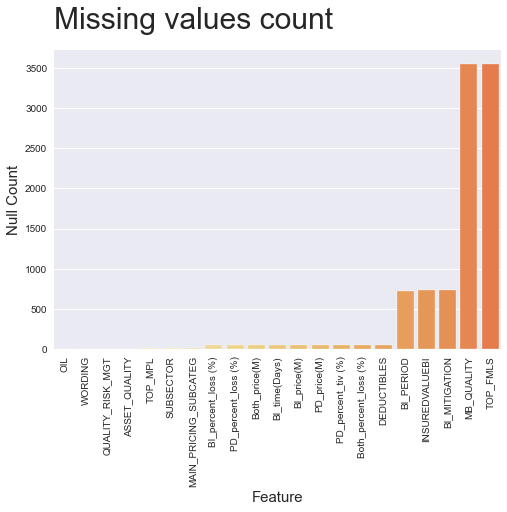

In [6]:
sns.set_style('darkgrid')

def null_vals(df): 
    df = df.isna().sum().to_frame()
    df = df[df.iloc[:, 0] != 0]
    df.rename({0:'Null Count'}, axis=1, inplace=True)
    df['% Null'] = (df['Null Count'] / len(df)) * 100
    df = df.sort_values(by='Null Count').reset_index()
    color = sns.color_palette('YlOrRd', 20) if len(df) < 20 else sns.color_palette('YlOrRd', 37)
    sns.barplot(data = df, x='index', y='Null Count', palette=color)
    plt.tick_params(axis='both', labelsize=10)
    plt.tick_params(axis='x', labelrotation=90)
    title = 'Missing values count'
    plt.title(title, fontsize=30, loc='Left', y=1.05)
    plt.xlabel('Feature', fontsize=15)
    plt.ylabel('Null Count', fontsize=15)  
        
        
null_vals(df)

In [7]:
# impute missing values
def missing_val_imputer(df):

    df['SUBSECTOR'] = df['SUBSECTOR'].fillna('UNSPECIFIED')
    df['BI_PERIOD'] = df['BI_PERIOD'].fillna(0) #BI Not insured -> 0, but there are 5 with COVERAGE = PD,BI but this column is nan
    df["TOP_FMLS"] = df["TOP_FMLS"].fillna(0) #there are only 5 exmaples where TOP_FMLS and TOP_MPL are both nan
    df["TOP_MPL"] = df["TOP_MPL"].fillna(0)
    df["OIL"] = df["OIL"].fillna(0)
    df["WORDING"] = df["WORDING"].astype(str) # nan as a new type
    df["QUALITY_RISK_MGT"] = df["QUALITY_RISK_MGT"].fillna('Average') 
    df["ASSET_QUALITY"] = df["ASSET_QUALITY"].fillna('Average')
    df["BI_MITIGATION"] = df["BI_MITIGATION"].fillna('Non applicable')
    df["MB_QUALITY"] = df["MB_QUALITY"].fillna('Average')
    df["MAIN_PRICING_SUBCATEG"] = df["MAIN_PRICING_SUBCATEG"].fillna('Others')
    df["INSUREDVALUEBI"] = df["INSUREDVALUEBI"].fillna(0.) # nan -> Coverage == "BI"
    df.fillna(0, inplace=True)
    
    return df

In [8]:
imputed = missing_val_imputer(df.copy())


# <font color='darkorange'>3. Exploratory Analysis </font>

## <font color='darkorange'>3.1 Corelation check</font>

We want to have a sense of which data is closley related to target.

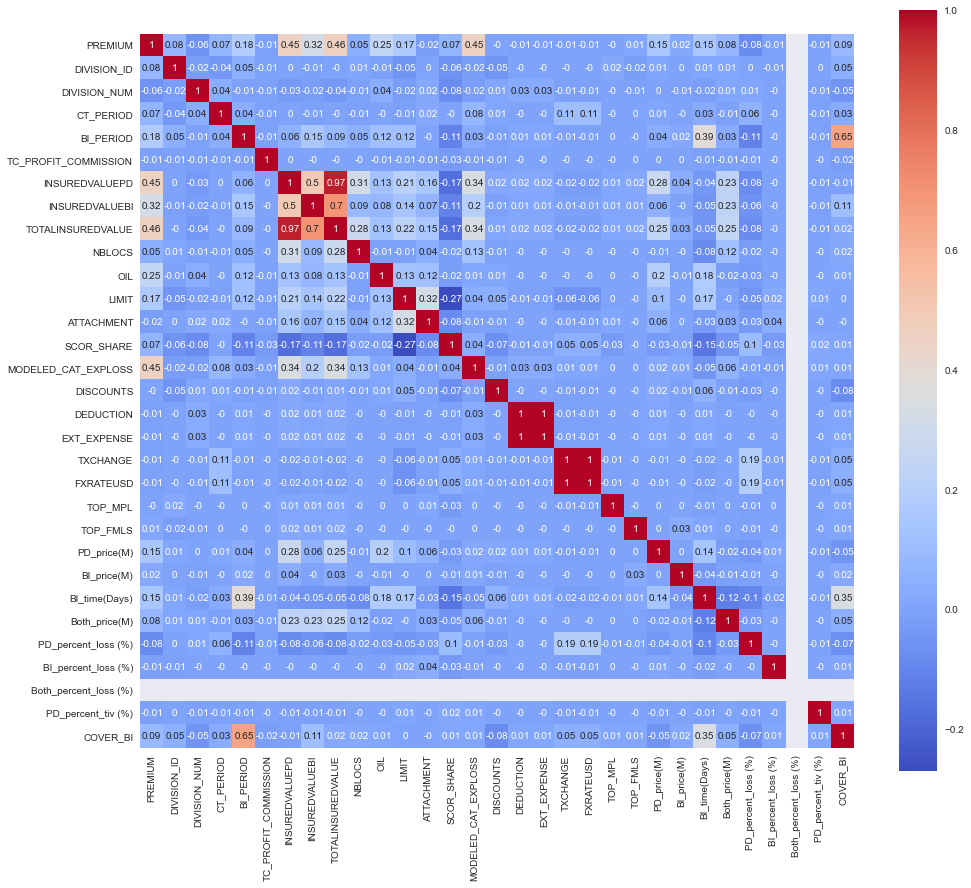

In [9]:

def corr_plot(df):
    corr_df = df.corr().round(2) # rounding to 1 decimal point to make it easier to observe correlated features
    plt.figure(figsize=(16, 14))
    sns.heatmap(corr_df, cmap='coolwarm', annot=True, square=True, annot_kws=dict(size=10), cbar=True)
    plt.show()


corr_plot(imputed)

* First, we can observe two red squares around (DEDUCTION and EXT_EXPENSE), (TXCHANGE and FXRATEUSD) and around INSUREDVALUE features, this shows high correlation between these features, we might have to drop some features here and pick the best one out. 

* Second, we have some columns which are best correlated with the target (abs >0.1). Let's see them:


In [10]:
coor_dict = df.corr()['PREMIUM'].sort_values(ascending=False).to_dict()
best_columns=[]
for key,value in coor_dict.items():
    if (abs(value)> 0.1 and abs(value) < 0.9):
        best_columns.append((key, value))
best_columns

[('TOTALINSUREDVALUE', 0.46450625371199156),
 ('MODELED_CAT_EXPLOSS', 0.45436233456207303),
 ('INSUREDVALUEPD', 0.4518977516781643),
 ('INSUREDVALUEBI', 0.32724031532602105),
 ('OIL', 0.2528952215430098),
 ('BI_PERIOD', 0.17602348179122176),
 ('LIMIT', 0.16832671791797224),
 ('BI_time(Days)', 0.1599298053009472),
 ('PD_price(M)', 0.1556563685608131)]

As expected, the features related to insured values have the highest correlation. However, we can reason that there are many other features that influence PREMIUM. 

## <font color='darkorange'>3.2 Insepcting various feature types</font>

As defined earlier, We are working with mainly 4 types of features:

* Nominal Type : labels do not express implicit order
* Ordinal Type : labels have an implicit order
* Numerical / Continuous features
* Temporal features


We will explore them one by one.



### <font color='darkorange'>3.2.1 Nonimal variables</font>

First we plot the variables and see their distribution.

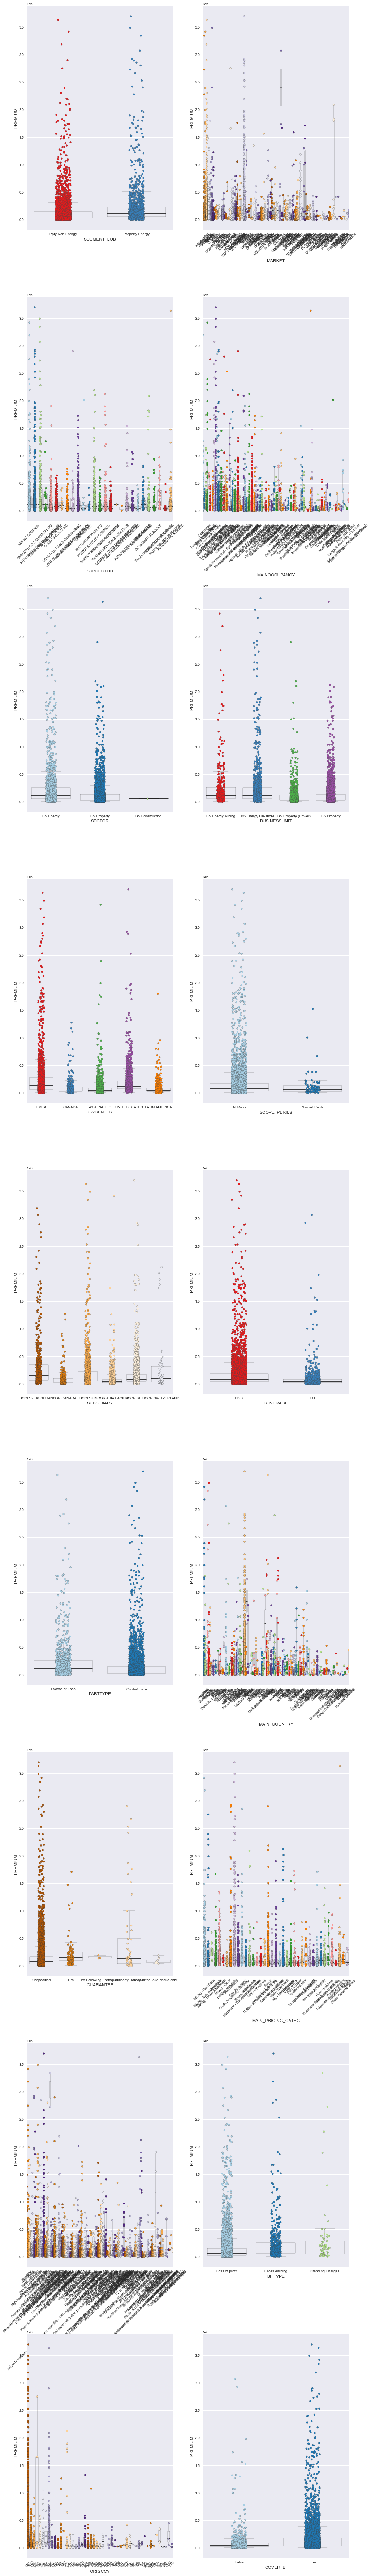

In [11]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth':0.3},
    'medianprops':{'color':'black', 'linewidth':1.5},
    'whiskerprops':{'color':'black', 'linewidth':0.3},
    'capprops':{'color':'black', 'linewidth':0.3},
} 


nominal_to_plot = [x for x in nominal_features if x not in bookkeeping_features]


fig, ax = plt.subplots(9, 2, figsize=(16, 130))
plt.subplots_adjust(hspace=0.3)

for i, feature in enumerate(nominal_to_plot):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(9, 2, i+1)
    sns.boxplot(x=feature, data=imputed, y='PREMIUM', showfliers=False,  **PROPS) # stage 2
    sns.stripplot(x=feature, data=imputed, y='PREMIUM', palette=colors, linewidth=0.3)
    if imputed[feature].nunique() > 10:
        plt.tick_params(axis='x', labelsize=9, labelrotation=45)
    plt.xlabel(feature, fontsize=12) 
    plt.ylabel('PREMIUM', fontsize=12)



Base on the distributions of the features, we will employ different strategies in treating them:

* If the feature contains mostly one type of labels, drop that feature to prevent overiftting

* If we have many similar mean target values across labels, we combaine them to reduce cardinality


Following these strategies, we will keep as it is:

* **SEGMENT_LOB**
* **PARTTYPE**
* **SUBSIDIARY**
* **COVER_BI**
* **BI_TYPE**


And we try to combine:
* **SECTOR**: BS Construction + BS Property = BS CP
* **GUARANTEE**: Property Damage + Fire + Fire Following Earthquake = PFF, earthquake-shake + unspecified  = EU
* **BUSINESSUNIT**: BS Property(Power) + BS Property = BS P, BS Energy On-shores + BS Energy Mining = BS E
* **UWCENTER**: LATIN AMERICA + ASIA PACIFIC + CANADA  = LAC
* **SUBSECTOR**:

ONSHORE CO & CHEMICAL CO + HEALTHCARE + MINING COMPANY + OFFSHORE (E&P) COMPANY + CONSTRUCTION & ENGINEERING + CEDANTS FACULTATIVES SERVICES + HEAVY INDUSTRIES + UNSPECIFIED = HEAVY, 

HIGH TECH. INDUSTRIES + CONSUMER SERVICES + AGRICULTURAL/LIFE SCIENCES + POWER & UTILITY COMPANY + CONSUMER GOODS + OTHER INDUSTRIES + SECTOR UNSPECIFIED + AUTOMOTIVE & PARTS + OTHER SERVICES = LIGHT_1,

TRANSPORTATION & LOGISTICS + CORPORATE PROPERTY & CASUALTY + ENVIRONMENTAL SERV. & IND. + TELECOMMUNICATIONS & MEDIA + ENERGY & NATURAL RESOURCES + FINANCIAL INSTITUTIONS + PROFESSIONAL SERVICES = LIGHT_2


In [12]:
# combines lables to reduce cardinalities

def label_combiner(df_org):
    df = df_org.copy()

    df.SECTOR.replace({'BS Construction':'BS CP', 'BS Property':'BS CP'}, 
                      inplace=True)
    
    df.GUARANTEE.replace({'Property Damage':'PFF', 
                          'Fire Following Earthquake':'PFF',
                          'Fire':'PFF',
                          'Unspecified': 'EU',
                          'Earthquake-shake only': 'EU'},
                          inplace=True)
    
    df.BUSINESSUNIT.replace({'BS Property': 'BS Property',
                             'BS Property (Power)': 'BS Property',
                             'BS Energy On-shore': 'BS Energy',
                             'BS Energy Mining': 'BS Energy'},
                            inplace=True)
    
    df.UWCENTER.replace({'LATIN AMERICA': 'LAC',
                         'ASIA PACIFIC': 'LAC',
                         'CANADA': 'LAC'},
                        inplace=True)
    
    
    df.SUBSECTOR.replace({'ONSHORE CO & CHEMICAL CO': 'HEAVY',
                          'HEALTHCARE': 'HEAVY',
                          'MINING COMPANY': 'HEAVY',
                          'OFFSHORE (E&P) COMPANY': 'HEAVY',
                          'CONSTRUCTION & ENGINEERING': 'HEAVY',
                          'CEDANTS FACULTATIVES SERVICES': 'HEAVY',
                          'HEAVY INDUSTRIES': 'HEAVY',
                          'UNSPECIFIED': 'HEAVY'}, 
                         inplace=True)
    
    df.SUBSECTOR.replace({'HIGH TECH. INDUSTRIES': 'LIGHT_1',
                          'CONSUMER SERVICES': 'LIGHT_1',
                          'AGRICULTURAL/LIFE SCIENCES': 'LIGHT_1',
                          'POWER & UTILITY COMPANY': 'LIGHT_1',
                          'CONSUMER GOODS': 'LIGHT_1',
                          'OTHER INDUSTRIES': 'LIGHT_1',
                          'SECTOR UNSPECIFIED': 'LIGHT_1',
                          'AUTOMOTIVE & PARTS': 'LIGHT_1',
                          'OTHER SERVICES': 'LIGHT_1'}, 
                         inplace=True)
    
    
    df.SUBSECTOR.replace({'TRANSPORTATION & LOGISTICS': 'LIGHT_2',
                           'CORPORATE PROPERTY & CASUALTY' :'LIGHT_2',
                           'ENVIRONMENTAL SERV. & IND.' :'LIGHT_2',
                           'TELECOMMUNICATIONS & MEDIA' :'LIGHT_2',
                           'ENERGY & NATURAL RESOURCES' :'LIGHT_2',
                           'FINANCIAL INSTITUTIONS' :'LIGHT_2',
                          'PROFESSIONAL SERVICES': 'LIGHT_2'
                          }, 
                          inplace=True)
    
    return df

For the following features: 
* **ORIGCCY**
* **MARKET** 
* **MAIN_COUNTRY** 

They are closely related, since all of them offer geographical market segment information. Instead of grouping them based on similar target mean, we can use a more general concept: **GEO_MARKET_SEGMENT**, defined to have one of the following values: https://www.wto.org/english/res_e/statis_e/technotes_e.htm

The advanatage of **GEO_MARKET_SEGMENT** is that it groups country/region not only based on geographical information, but also their economic performance, which is an important factor in market insurance. 




In [13]:
geo_market_segment_dict = {}
geo_market_segment_dict['North America'] = set(['Canada', 'United States of America', 'UNITED STATES', 'Puerto Rico'])

geo_market_segment_dict['Latin America'] = set(['Antigua and Barbuda', 'Argentina', 'Bahamas', 'Barbados', 
                                                'Belize', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 
                                                'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 
                                                'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica',
                                                'Mexico', 'Netherlands Antilles', 'Nicaragua', 'Panama', 'Paraguay',
                                                'Peru', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 
                                                'Suriname', 'Trinidad and Tobago', 'Uruguay', 'Venezuela'])

geo_market_segment_dict['Western Europe'] = set(['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 
                                                 'Greece', 'Iceland', 'Ireland', 'Italy', 'Liechtenstein', 'Monaco',
                                                 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Portugal', 
                                                 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 
                                                 'Bosnia and Herzegovina', 'Croatia', 'former Yugoslav Republic of Macedonia', 
                                                 'Slovenia', 'Yugoslavia'])

geo_market_segment_dict['Central and Eastern Europe'] = set(['Albania', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 
                                                             'Romania','the Slovak Republic', 'Estonia', 'Latvia', 'Lithuania',
                                                             'Armenia', 'Azerbaijan', 'Belarus', 'Georgia', 'Kazakhstan', 'Kyrgyz Repubic', 
                                                             'Republic of Moldova', 'Russian Federation', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine',
                                                             'Uzbekistan'])



geo_market_segment_dict['Africa'] = set(['Algeria', 'Egypt', 'Libyan Arab Jamahiriya', 'Morocco', 'Tunisia',
                                         'Benin', 'Burkina Faso', 'Cape Verde', 'Ivory Coast', 'Gambia', 
                                         'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 
                                         'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo', 'Burundi', 'Cameroon', 
                                         'Central African Republic', 'Chad', 'Congo', 'Democratic Republic of the Congo', 
                                         'Equatorial Guinea', 'Gabon', 'Rwanda', 'Sao Tome and Principe', 'Comoros', 
                                         'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Mauritius', 'Seychelles', 
                                         'Somalia', 'Sudan', 'United Republic of Tanzania', 'Tanzania', 'Uganda', 'Angola', 'Botswana', 
                                         'Lesotho', 'Malawi', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 
                                         'Zimbabwe'])

geo_market_segment_dict['Middle East'] = set(['Bahrain', 'Cyprus', 'Iraq', 'Islamic Republic of Iran', 'Iran', 'Israel', 'Jordan', 
                                              'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic', 
                                              'United Arab Emirates', 'Yemen'])




geo_market_segment_dict['Mature Asia'] = set(['Australia','Hong Kong', 'Japan', 'New Zealand', 'Taiwan', 'Singapore', 'Republic of Korea', 'South Korea'   ])

geo_market_segment_dict['Emerging Asia'] = set(['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Maldives', 'Nepal', 'Pakistan', 'Sri Lanka', 
                                                'Brunei Darussalam', 'Brunei', 'Cambodia', 'China', 'Fiji', 'Indonesia', 'Kiribati', "Lao People's Democratic Republic", 
                                                'Laos','Macau', 'Malaysia', 'Mongolia', 'Myanmar', 'Papua New Guinea', 'Philippines', 'Samoa', 'Myanmar (Burma)',
                                                'Solomon Islands', 'Thailand', 'Tonga', 'Tuvalu', 'Vanuatu', 'Vietnam', ])



# use the geo_market dictionary to create the new predictor GEO_MARKET_SEGMENT
def convert_geo_market_segment(df):
    df['GEO_MARKET_SEGMENT'] = 'Others'
  
    mask1 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['North America']) 
    mask2 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Latin America']) 
    mask3 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Western Europe']) 
    mask4 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Central and Eastern Europe']) 
    mask5 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Africa']) 
    mask6 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Middle East']) 
    mask7 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Mature Asia']) 
    mask8 = df['MAIN_COUNTRY'].isin(geo_market_segment_dict['Emerging Asia']) 


    df.loc[mask1, 'GEO_MARKET_SEGMENT'] = 'North America'
    df.loc[mask2, 'GEO_MARKET_SEGMENT'] = 'Latin America'
    df.loc[mask3, 'GEO_MARKET_SEGMENT'] = 'Western Europe'
    df.loc[mask4, 'GEO_MARKET_SEGMENT'] = 'Central and Eastern Europe'
    df.loc[mask5, 'GEO_MARKET_SEGMENT'] = 'Africa'
    df.loc[mask6, 'GEO_MARKET_SEGMENT'] = 'Middle East'
    df.loc[mask7, 'GEO_MARKET_SEGMENT'] = 'Mature Asia'
    df.loc[mask8, 'GEO_MARKET_SEGMENT'] = 'Emerging Asia'
  

    return df

In [14]:

imputed = label_combiner(imputed)
imputed = convert_geo_market_segment(imputed.copy())

### <font color='darkorange'>3.2.2 Ordinal Variables</font>

Again we begin with some plotting.

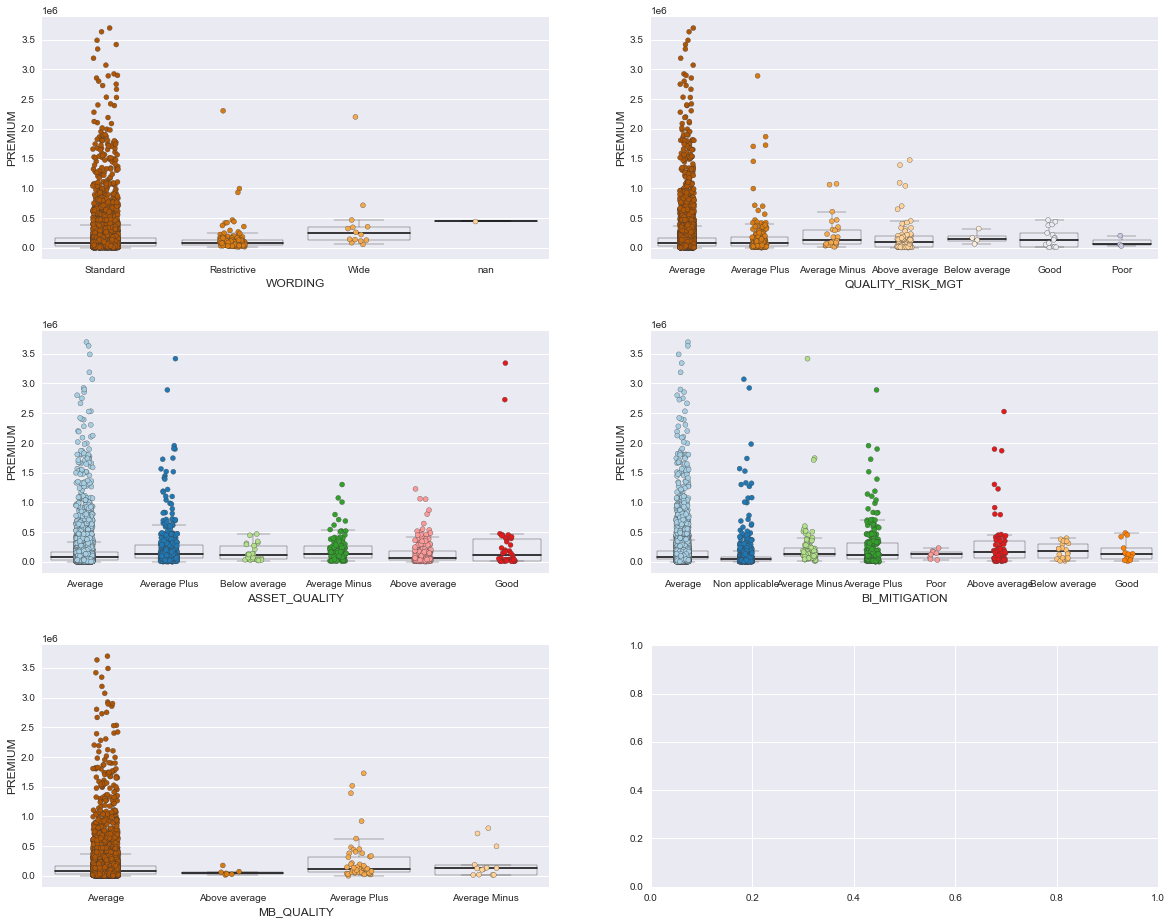

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.3)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth':0.3},
    'medianprops':{'color':'black', 'linewidth':1.5},
    'whiskerprops':{'color':'black', 'linewidth':0.3},
    'capprops':{'color':'black', 'linewidth':0.3},
} 


for i, feature in enumerate(ordinal_features):
    colors = np.random.choice([palette_1, palette_2, palette_3])
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=feature, data=imputed, y='PREMIUM', showfliers=False,  **PROPS) # stage 2
    sns.stripplot(x=feature, data=imputed, y='PREMIUM', palette=colors, linewidth=0.3)
    if imputed[feature].nunique() > 10:
        plt.tick_params(axis='x', labelsize=9, labelrotation=45)
    plt.xlabel(feature, fontsize=12) 
    plt.ylabel('PREMIUM', fontsize=12) 

We can see there are some problems with the ordinal features:

* High concentration of target value in one or two certain labels.
* No big different between group mean.
* No clear positive/negative trend between the ordinal features and the target.


### <font color='darkorange'>3.2.3 Numerical Variables</font>



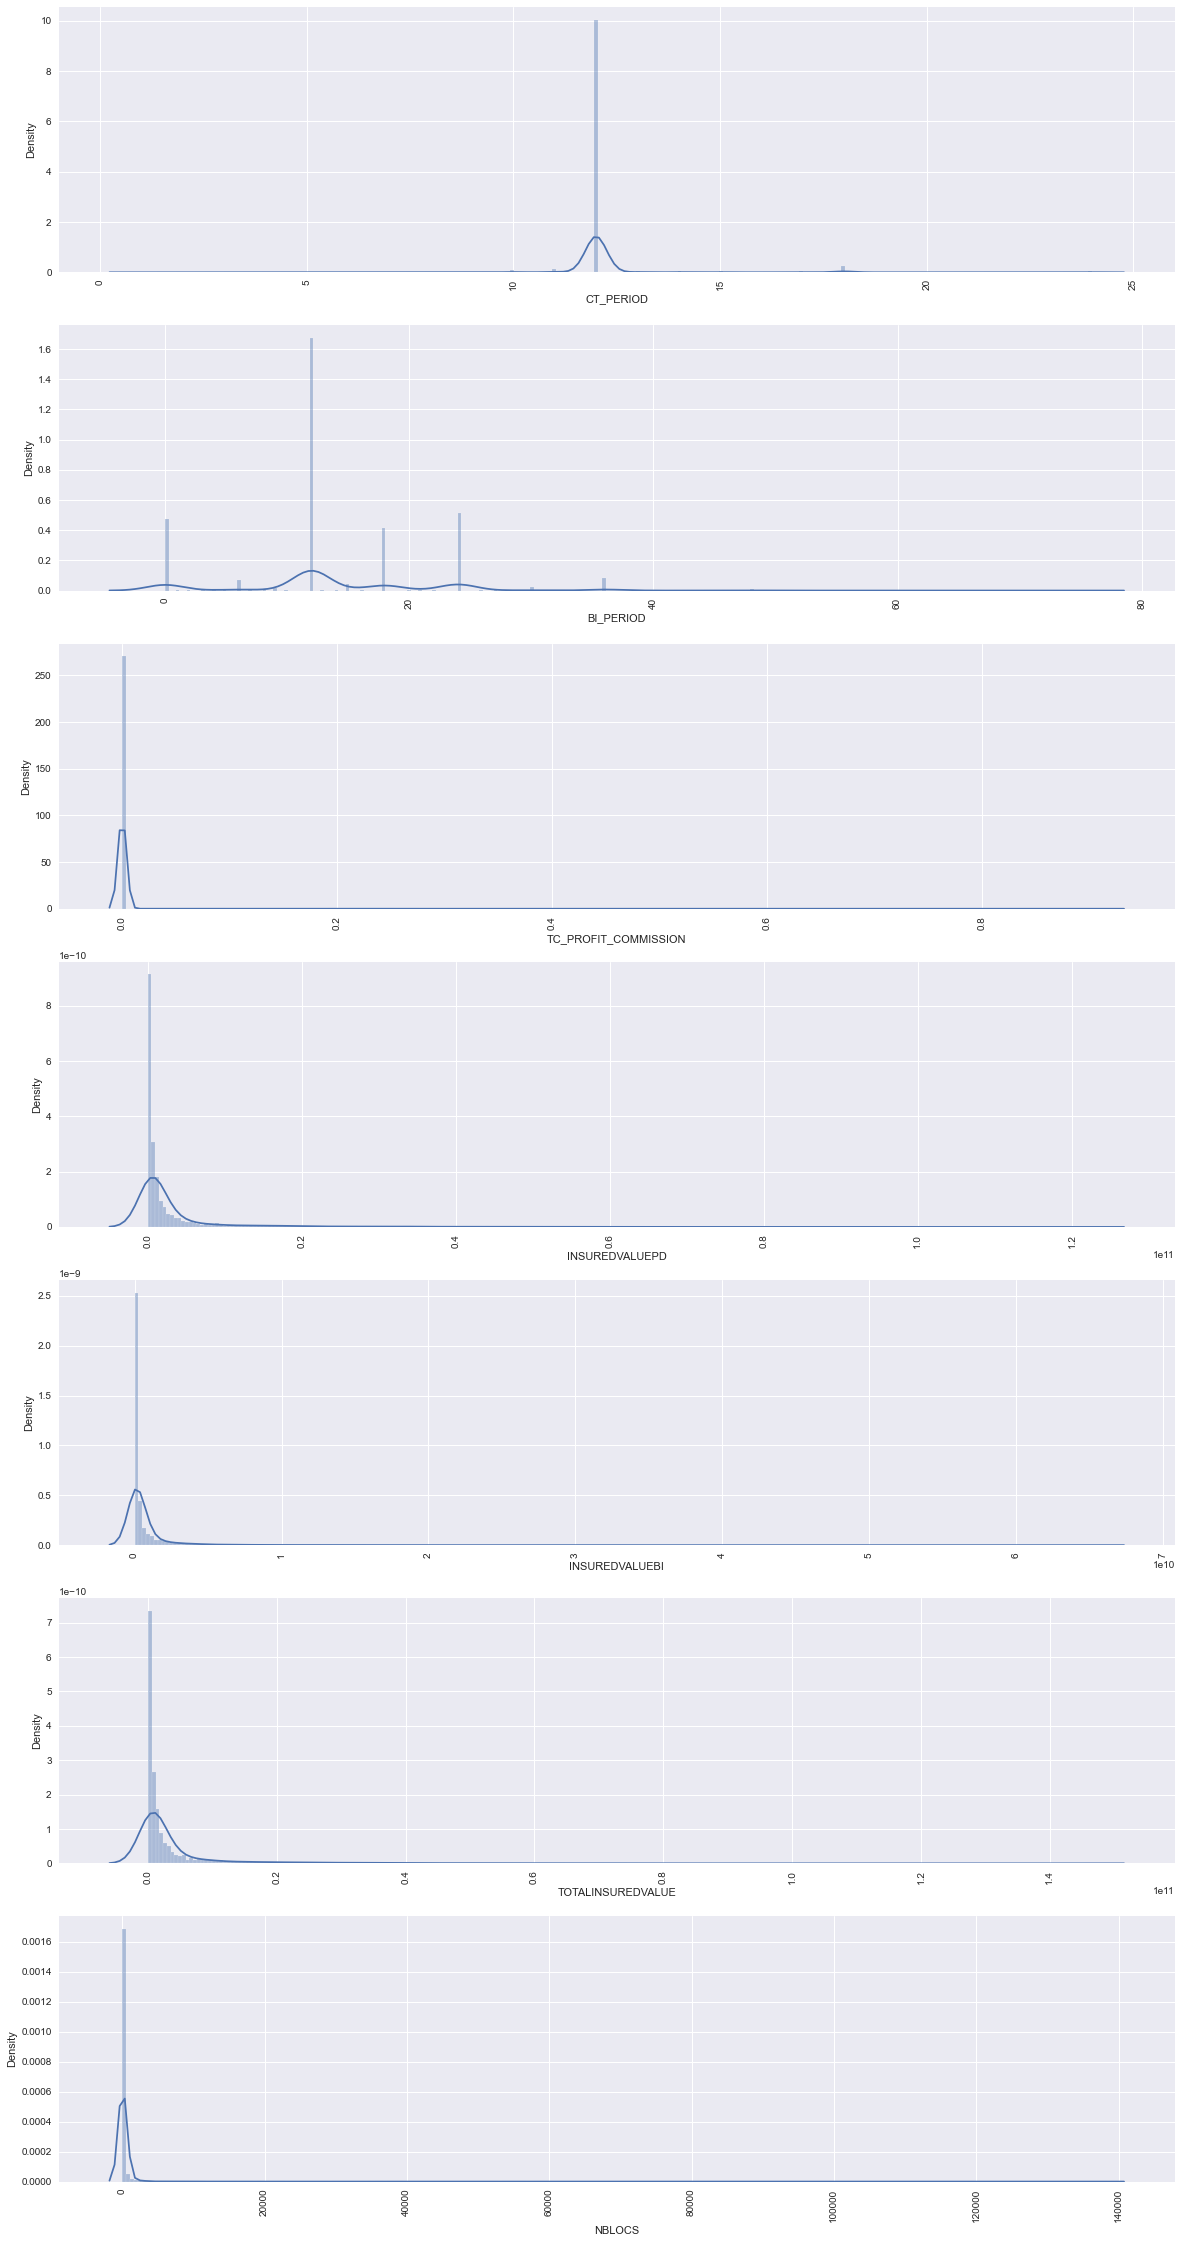

In [16]:
fig, ax = plt.subplots(7, 1, figsize=(20, 40))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.distplot(imputed[variable], ax=subplot, bins=250)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

First we pick out any highly skewed features, and log transform them.

In [17]:
skewed_features = imputed[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

EXT_EXPENSE              69.036172
DEDUCTION                69.036172
BI_percent_loss (%)      50.921512
TOP_MPL                  50.837258
TOP_FMLS                 49.777902
BI_price(M)              33.408781
PD_percent_tiv (%)       31.600369
TC_PROFIT_COMMISSION     26.469144
NBLOCS                   22.576599
PD_price(M)              18.877992
DISCOUNTS                18.774766
ATTACHMENT               16.695408
Both_price(M)            16.662224
MODELED_CAT_EXPLOSS      12.588710
FXRATEUSD                11.523646
TXCHANGE                 11.520890
INSUREDVALUEBI           10.803366
OIL                       7.868650
LIMIT                     6.556417
INSUREDVALUEPD            5.818203
TOTALINSUREDVALUE         5.681395
PD_percent_loss (%)       4.304125
CT_PERIOD                 2.556021
XXX_SHARE                2.542736
BI_time(Days)             0.918330
BI_PERIOD                 0.719052
Both_percent_loss (%)     0.000000
dtype: float64


In [18]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

for feature in skewed_features:
    if feature != 'PREMIUM':
        imputed[feature] =  np.log1p(imputed[feature])

        

### <font color='darkorange'>3.2.4 Temporal Variables</font>

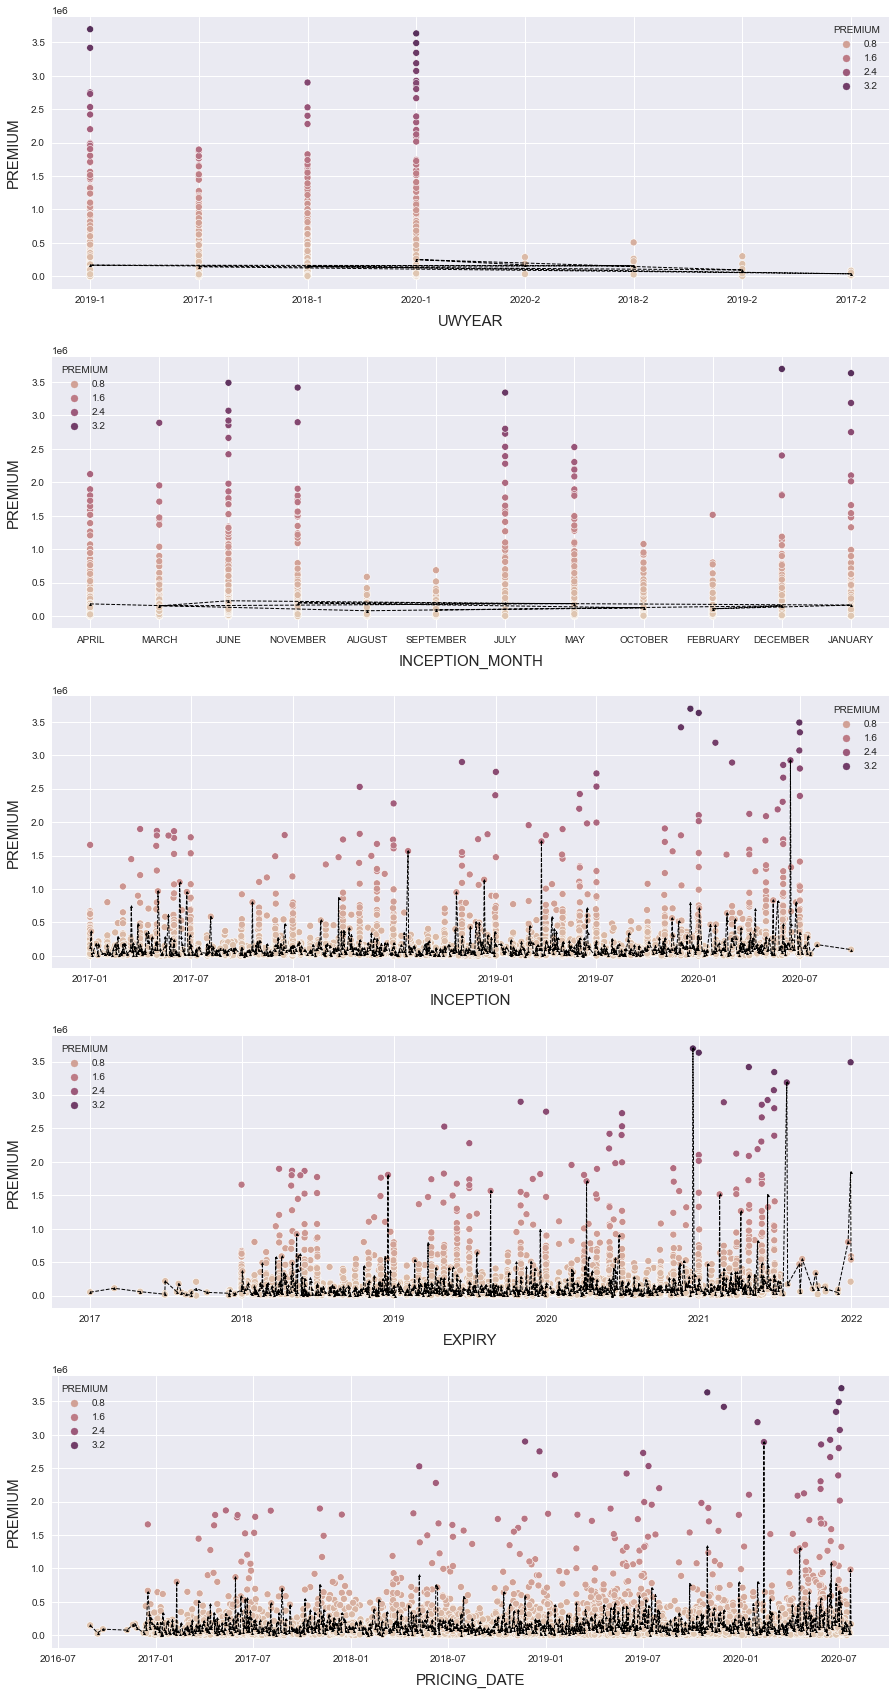

In [19]:
fig, ax = plt.subplots(5, 1, figsize=(15, 30)) 
plt.subplots_adjust(hspace=.25)


cmap_2 = sns.cubehelix_palette(rot=.5, dark=0.25, light=0.8, as_cmap=True)

for i, feature in enumerate(temporal_features):
    feature_series = imputed.groupby(feature).PREMIUM.mean()
    
    sns.scatterplot(data=imputed, x=feature, y='PREMIUM',  hue='PREMIUM', palette=cmap_2, ax=ax[i], zorder=1)
    ax[i].plot(feature_series, '^k--', markersize=3, linewidth=1)
    ax[i].set_xlabel(f'{feature}', fontsize=15, labelpad=10)
    ax[i].set_ylabel('PREMIUM', fontsize=15, labelpad=10)

    
    
sns.set_style('darkgrid')
plt.show()

The premiums seem to be increasing over the different **UW_YEAR**. The trend on a finer scale such as **MONTH** however, is not very clear. 

With the above analysis, we can temporarily drop some distracting columns from our dataset.

In [20]:
TO_DROP = ['DIVISION_NUM',
	'CT_STATUS',
	'UF_STATUS',
	'TAG',
	'REPORTCCY',
	'DIVISION_ID',
	'COVERAGE',
	'DEDUCTIBLES',
	'ORIGCCY',
	'MARKET',
	'MAIN_COUNTRY',
	'MAIN_PRICING_SUBCATEG',
	'SUBSECTOR',
	'INCEPTION_MONTH',
	'INCEPTION',
	'EXPIRY',
	'PRICING_DATE']

imputed.drop(columns=TO_DROP, inplace=True)


## <font color='darkorange'> 3.3 Dimensionality reduction </font>

We still have many features. We can perform dimensionality reduction to bring the high dimension data close to its intrinsic dimension.

Let's begin with PCA of the numerical features.

In [21]:
imputed_num = imputed.select_dtypes(include=['float64', 'int64'])
imputed_num_X = imputed_num.drop(columns=['PREMIUM'])

Text(0, 0.5, 'Explanined variance ratio for number of components')

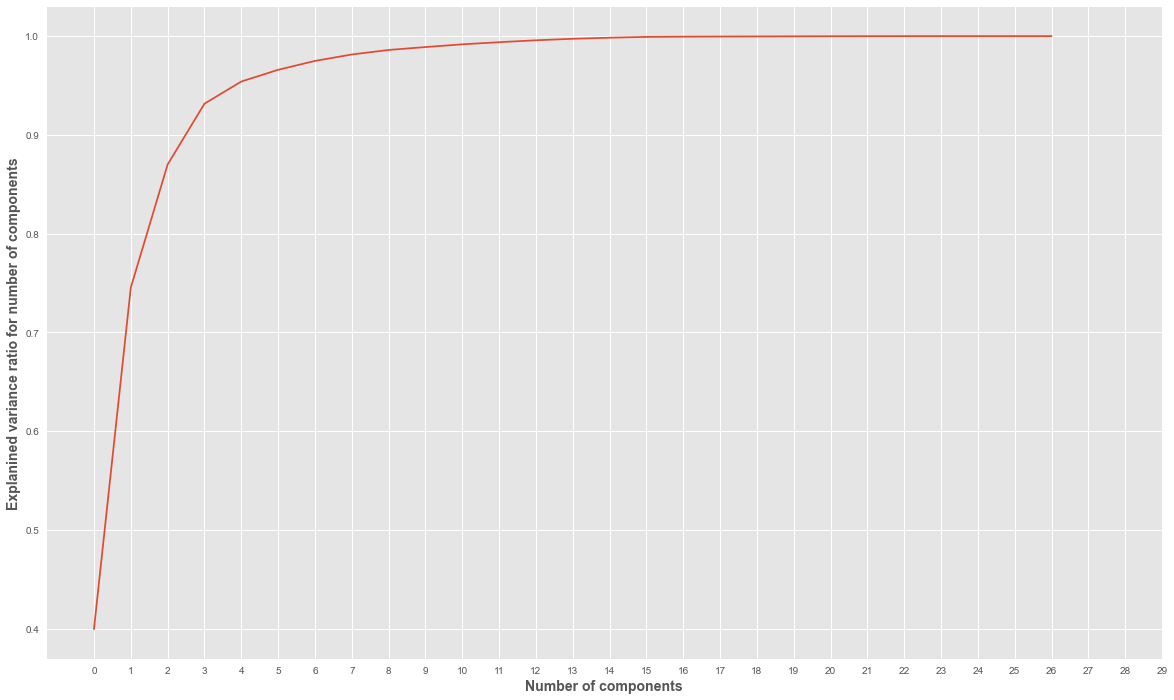

In [22]:
plt.style.use('ggplot')
plt.figure(figsize=(20,12))
rbst_scaler=RobustScaler()
imputed_num_rbst=rbst_scaler.fit_transform(imputed_num_X)

pca=PCA(27).fit(imputed_num_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 30, 1))
plt.xlabel('Number of components',fontweight='bold',size=14)
plt.ylabel('Explanined variance ratio for number of components',fontweight='bold',size=14)


In [23]:
pca=PCA(3)
weights = pca.fit_transform(imputed_num_rbst)
df_pca = pd.DataFrame(data=weights, columns=["pca_1", "pca_2", "pca_3"])
df_pca["premium"] = imputed_num['PREMIUM']
fig = px.scatter_3d(
    df_pca, 
    x="pca_1", 
    y="pca_2", 
    z="pca_3",
    hover_name="premium",
    color="premium",
    template="plotly_white"
)
fig.update_layout(height=700, width=700)
fig.show()

<img src="img/3d.png" width=600 /> 

In [28]:
pd.DataFrame(pca.components_,columns=imputed_num_X.columns,index = ['PC-1','PC-2','PC-3'])


CT_PERIOD  BI_PERIOD  TC_PROFIT_COMMISSION  INSUREDVALUEPD  \
PC-1   0.000049  -0.003397             -0.000019        0.011454   
PC-2  -0.000197  -0.011440              0.000059       -0.042351   
PC-3   0.002601   0.099057             -0.000049        0.012392   

      INSUREDVALUEBI  TOTALINSUREDVALUE    NBLOCS       OIL     LIMIT  \
PC-1       -0.016353           0.010739  0.006266 -0.000182  0.003286   
PC-2       -0.041738          -0.042188 -0.025306 -0.000776 -0.011597   
PC-3        0.229014           0.019733  0.026832  0.001143 -0.015929   

      ATTACHMENT  XXX_SHARE  MODELED_CAT_EXPLOSS  DISCOUNTS  DEDUCTION  \
PC-1    0.216950   -0.005024             0.002108   0.000095   0.694202   
PC-2   -0.971913    0.007507            -0.005486   0.000157   0.153006   
PC-3   -0.037954    0.021533             0.022356  -0.000186   0.037515   

      EXT_EXPENSE  TXCHANGE  FXRATEUSD   TOP_MPL  TOP_FMLS  PD_price(M)  \
PC-1     0.684546 -0.027582  -0.030044  0.006183  0.000332     0.010198   
PC-2     0.151725 -0.024634  -0.026981 -0.029743  0.005722    -0.006726   
PC-3     0.036358  0.657064   0.705531  0.006666 -0.009427     0.029161   

      BI_price(M)  BI_time(Days)  Both_price(M)  PD_percent_loss (%)  \
PC-1     0.000025      -0.001303      -0.000976            -0.000167   
PC-2     0.000135       0.010350      -0.013995             0.006755   
PC-3     0.000056       0.019446       0.013985             0.004027   

      BI_percent_loss (%)  Both_percent_loss (%)  PD_percent_tiv (%)  
PC-1             0.000059                    0.0           -0.000053  
PC-2            -0.000323                    0.0            0.000217  
PC-3            -0.000284                    0.0           -0.000953

From the results above, we see that PC-1 is most aligned with **DEDUCTION**  , PC-2 with **ATTACHMENT**, PC-3 with **FXRATEUSD**. 

From the 3D plot, it is clear that some clusters exist. However, there is no clear boundary between high and low **PREMIUM**. It could be interesting to compare models using PCA-reduced data with those using the original data. 

## <font color='darkorange'>3.4 Clustering & remove outliers</font>

To see if there is any outliers, we employ the DBSCAN algorithm. DBSCAN examines the density of data points in a neibourhood to determine which cluster the data points belong to. A outlier is thus a point that is too far from all other points. It is assigned a label of -1.

In [29]:
train_pca=PCA(5).fit_transform(imputed_num_rbst) # we use PCA-reduced dataset where the number of components = 5
dbscan = DBSCAN(eps=1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

Let's try to plot the outliers, if any.

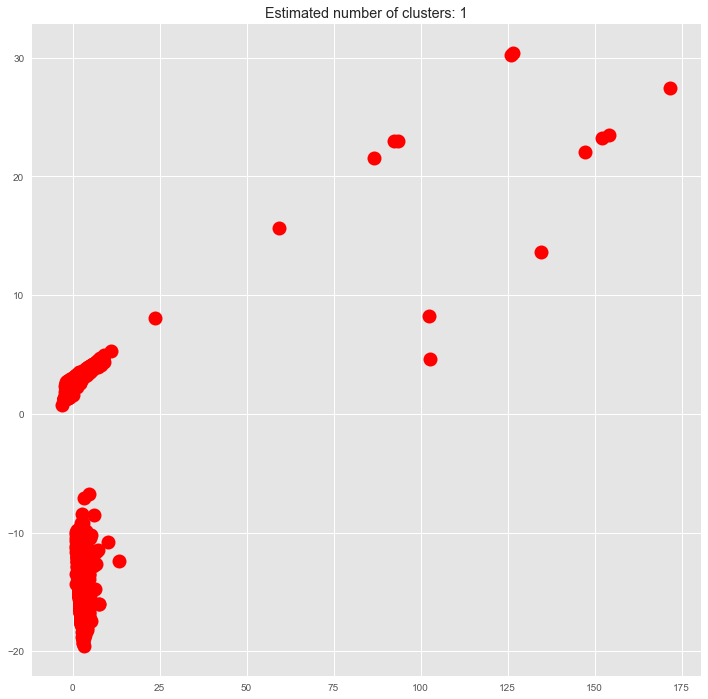

In [30]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [31]:
labels=pd.DataFrame(labels,columns=['Classes'])
len(labels[labels['Classes']==-1])

0

DBSCAN did not find any outliers

## <font color='darkorange'> Conclusion </font>

We have discovered certain trends in the data and performed a preliminary filtering/transforming of useful features. This notebook will serve as a basis for further data processing pipelines.